In [6]:
import tensorflow as tf
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
from glob import glob
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add, Attention, Reshape
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.utils import to_categorical,Sequence,plot_model
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [7]:
model = VGG16()
model = Model(inputs=model.input,outputs=model.layers[-2].output)

In [10]:
features={}
directory="/kaggle/input/flickr/Flickr8k_Dataset/Flicker8k_Dataset"
if not os.path.isfile("features.pkl"):
    for img_path in tqdm(glob(os.path.join(directory, "*.jpg"))):
        img = load_img(img_path, target_size=(224,224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = model.predict(x, verbose=0)
        img_id = os.path.basename(img_path).split('.')[0]
        features[img_id] = feature
    with open("features.pkl", "wb") as f:
        pickle.dump(features, f)
    print("features.pkl created")
else:
    print("features.pkl already exists — skipping dump")
!ls -lh features.pkl

100%|██████████| 8091/8091 [14:18<00:00,  9.43it/s]


features.pkl created
-rw-r--r-- 1 root root 127M Jun 29 06:08 features.pkl


In [11]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [12]:
captions_path = "/kaggle/input/flickr/Flickr8k_text/Flickr8k.token.txt"
captions_dict = {}
with open(captions_path,'r') as f:
    for line in f:
        img, cap = line.strip().split('\t')
        img = img.split('.')[0]
        cap = cap.lower()
        cap = re.sub(r'[^a-zA-Z\s]', '', cap)
        cap = re.sub(r'\s+', ' ', cap).strip()
        cap = "start " + cap + " end"
        captions_dict.setdefault(img, []).append(cap)
all_captions = []
for caps in captions_dict.values():
    all_captions.extend(caps)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1
max_length=max(len(cap.split()) for cap in all_captions)
common_keys = set(captions_dict.keys()) & set(features.keys())
captions_dict = {k: captions_dict[k] for k in common_keys}
img_ids = list(captions_dict.keys())
split = int(len(img_ids) * 0.9)
train = img_ids[:split]
test  = img_ids[split:]


In [13]:
def caption_example_generator(data_keys, captions_dict, features, tokenizer, max_length):
    while True:
        for key in data_keys:
            img_feat = features[key][0].astype(np.float32)
            for cap in captions_dict[key]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=max_length, padding='post')[0].astype(np.int32)
                    out_word = np.int32(seq[i])
                    yield (img_feat, in_seq), out_word

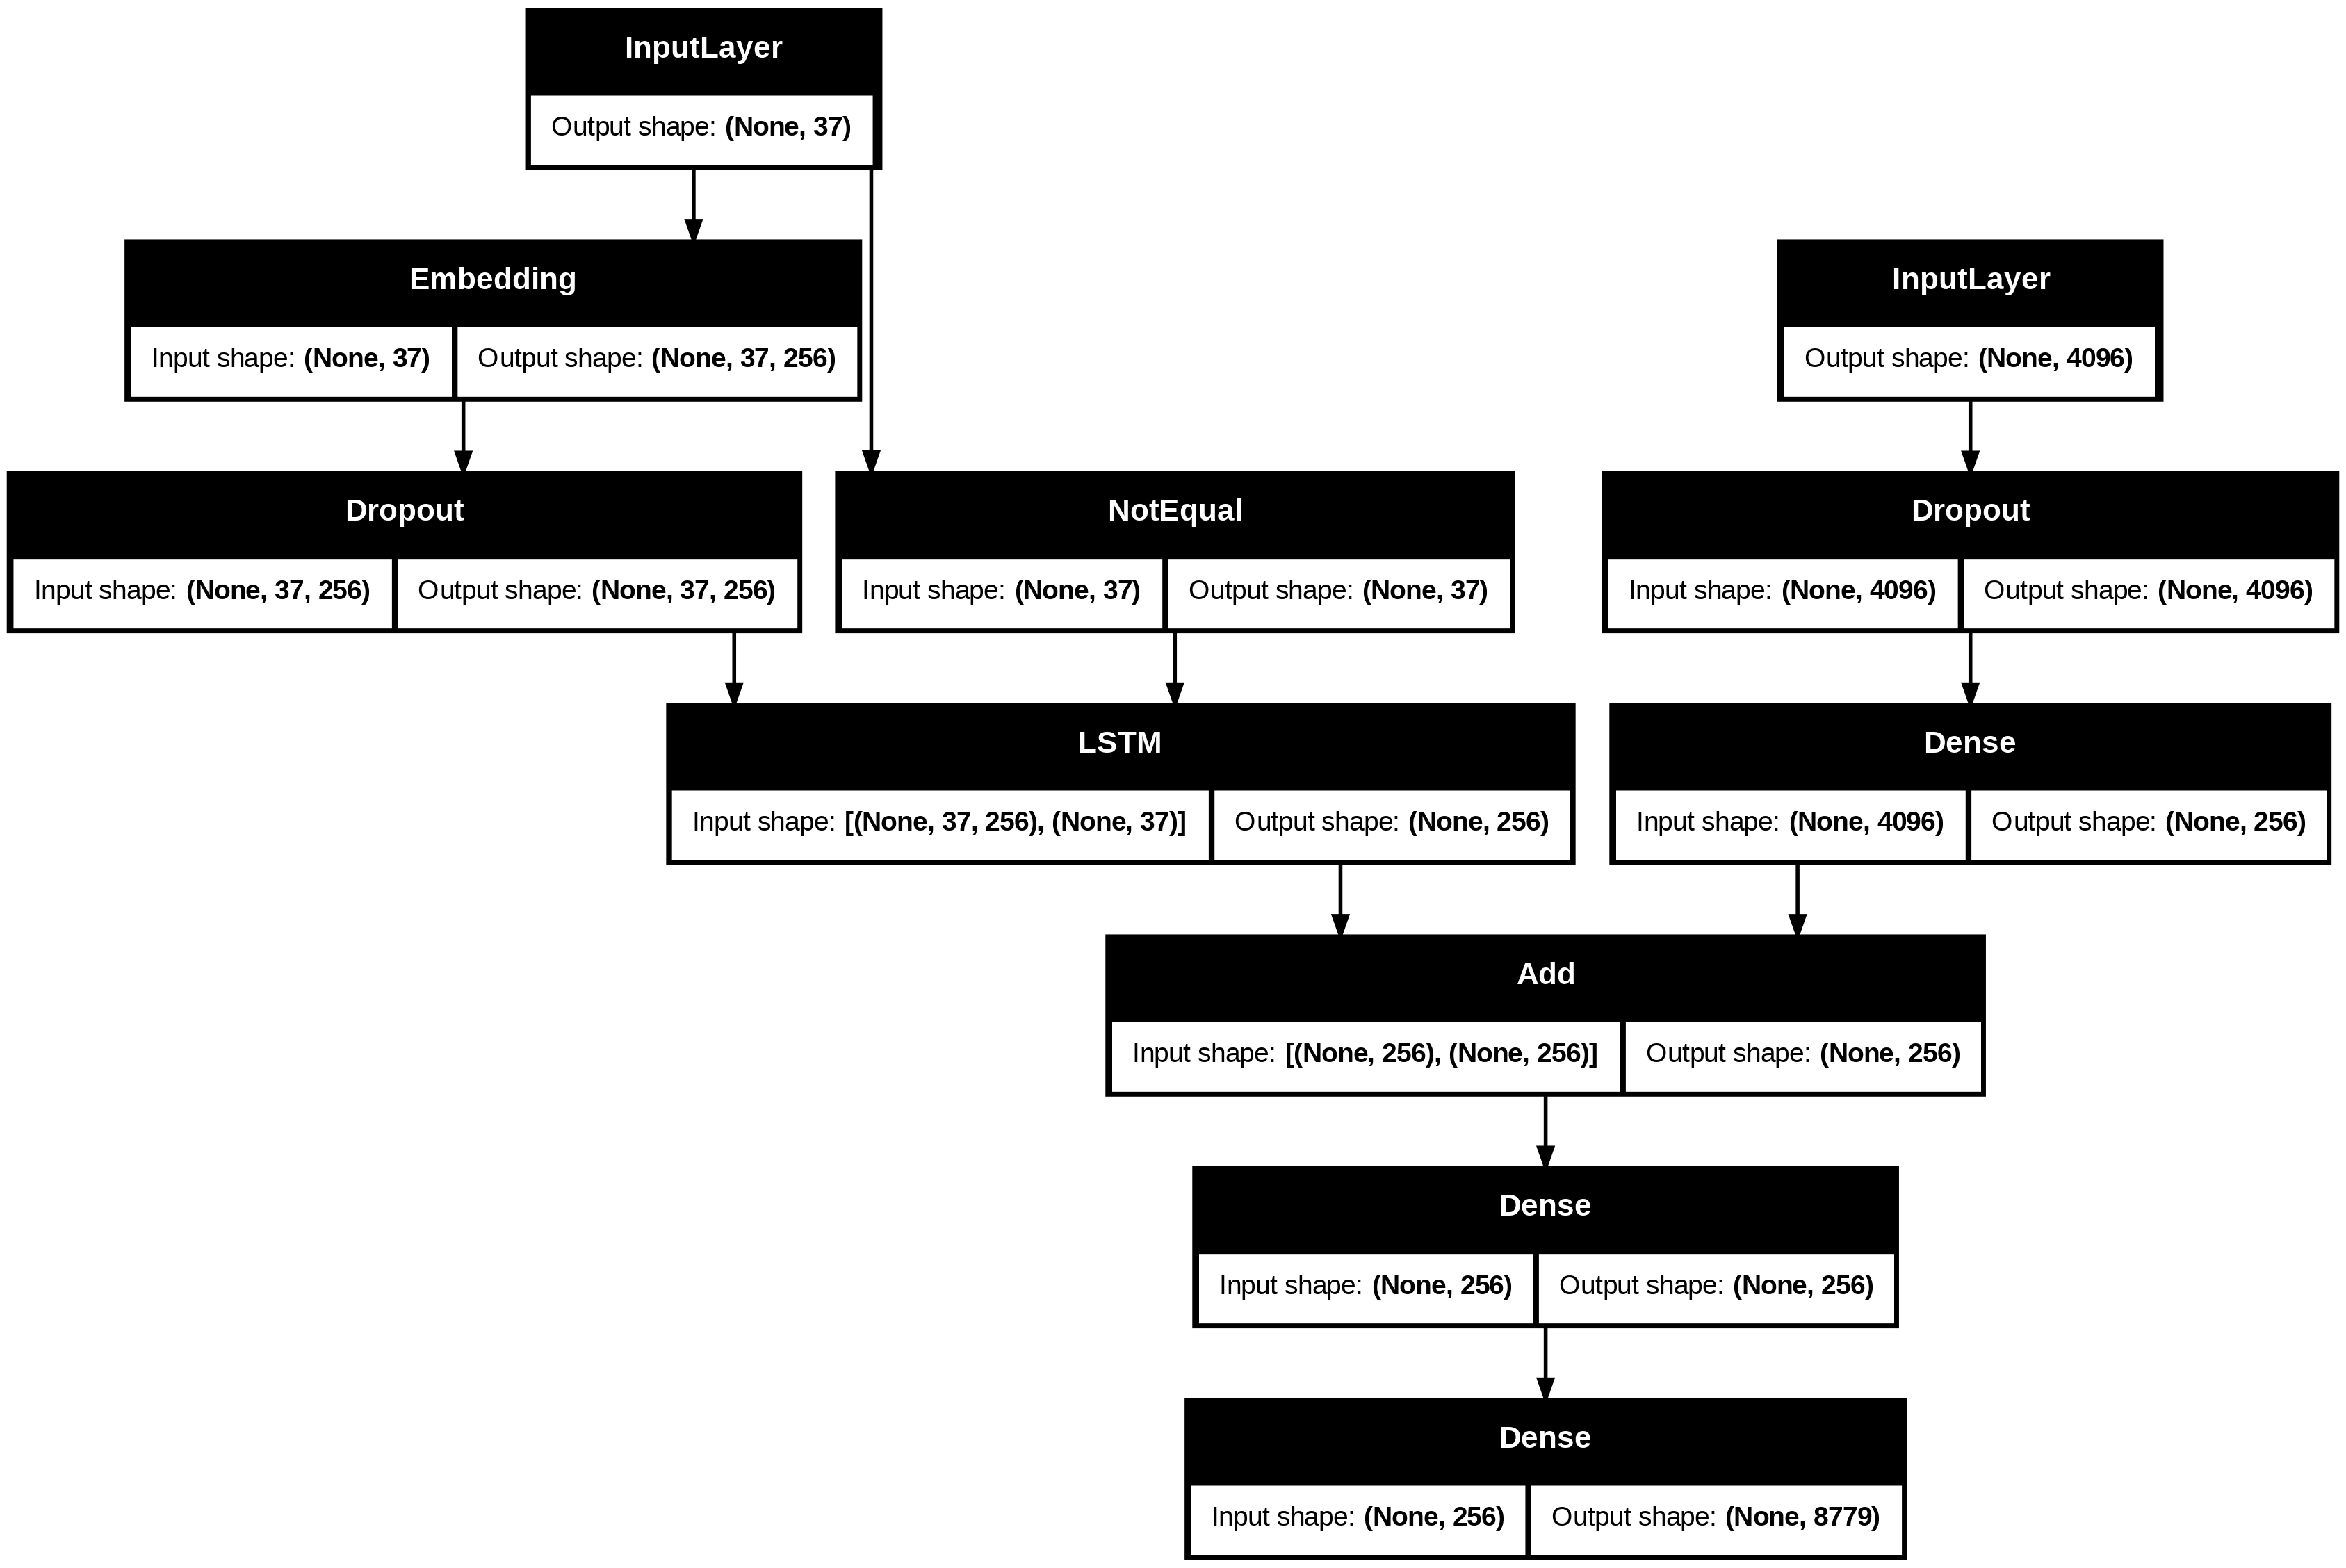

In [14]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [15]:
epoches = 5
batch_size = 64
output_types  = ((tf.float32, tf.int32), tf.int32)
output_shapes = (((4096,), (max_length,)), ())  
train_ds = tf.data.Dataset.from_generator(
    lambda: caption_example_generator(train, captions_dict, features, tokenizer, max_length),
    output_types=output_types,
    output_shapes=output_shapes
)
train_ds = train_ds.shuffle(10_000) \
                   .batch(batch_size) \
                   .map(
                       lambda inputs, y: (inputs, tf.one_hot(y, depth=vocab_size)),
                       num_parallel_calls=tf.data.AUTOTUNE
                   ) \
                   .prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_generator(
    lambda: caption_example_generator(test, captions_dict, features, tokenizer, max_length),
    output_types=output_types,
    output_shapes=output_shapes
)
val_ds = val_ds.batch(batch_size) \
               .map(
                   lambda inputs, y: (inputs, tf.one_hot(y, depth=vocab_size)),
                   num_parallel_calls=tf.data.AUTOTUNE
               ) \
               .prefetch(tf.data.AUTOTUNE)

total_train_samples = sum(
    (len(tokenizer.texts_to_sequences([cap])[0]) - 1)
    for key in train
    for cap in captions_dict[key]
)
total_val_samples = sum(
    (len(tokenizer.texts_to_sequences([cap])[0]) - 1)
    for key in test
    for cap in captions_dict[key]
)

train_steps = total_train_samples // batch_size
val_steps   = total_val_samples   // batch_size
history=model.fit(
    train_ds,
    epochs=epoches,
    steps_per_epoch=train_steps,
    validation_data=val_ds,
    validation_steps=val_steps,
    verbose=1
)


Epoch 1/5
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 215s 31ms/step - loss: 4.2769 - val_loss: 3.5754
Epoch 2/5
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 204s 30ms/step - loss: 3.2581 - val_loss: 3.4836
Epoch 3/5
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 203s 30ms/step - loss: 3.0249 - val_loss: 3.4526
Epoch 4/5
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 204s 30ms/step - loss: 2.8964 - val_loss: 3.4932
Epoch 5/5
6698/6698 ━━━━━━━━━━━━━━━━━━━━ 208s 31ms/step - loss: 2.8156 - val_loss: 3.5294


In [16]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [17]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length ,padding= 'post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'end':
            break
    return in_text


In [18]:
actual, predicted= list(),list()

for key in tqdm(test):
    cap = captions_dict[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in cap]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1:",corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2:",corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

100%|██████████| 810/810 [12:45<00:00,  1.06it/s]


BLEU-1: 0.585316308763784
BLEU-2: 0.38953179750635153


In [19]:
from PIL import Image
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(directory, image_name)
    img = Image.open(img_path)
    captions = captions_dict[image_id]
    print("actual")
    for cap in captions:
        print(cap)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("predicted:")
    print(y_pred)
    plt.imshow(img)

actual
start two woman climbing rocks around the ocean end
start two women are climbing over rocks near to the ocean end
start two women climb on top of rocks in front of the ocean end
start two women in bathing suit on large rocks at the ocean end
start two women in bathing suits climb rock piles by the ocean end
predicted:
start a man is standing on a rock end


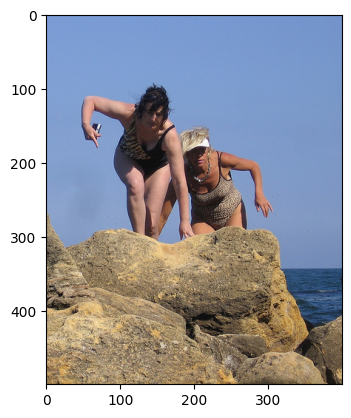

In [27]:
for img_id in test[4:5]:
    generate_caption(img_id+'.jpg')